In [1]:
# PROCESS THE GAIA CATALOG OF SOlAR ANALOGUES:
# Gaia has astrophysical parameters which can be used to find stars similar to the Sun
# Based on https://ui.adsabs.harvard.edu/abs/2023A%26A...674A..39G/abstract , we use Teff, logg, and M/H to find solar analogues
#
#
# ZACK REEVES
# CREATED: 2024
#
# VERSIONS:
#  1.1  JUN 2024 CREATE JUPYTER NOTEBOOK

In [2]:
import pandas as pd
import numpy as np
import sys
import os
import collections

import astropy.units as u
import astropy.coordinates
from astropy.table import Table, join, vstack
from astropy.io import ascii

from astroquery.gaia import Gaia

sys.path.insert(0, '..')
from common import file_functions, calculations, gaia_functions

from matplotlib import pyplot as plt, colors

In [3]:
# Define the metadata for the data set.  NEED TO EDIT
#https://ui.adsabs.harvard.edu/abs/2023A%26A...674A..39G/abstract
metadata = {}

metadata['project'] = 'Digital Universe Atlas Gaia Subsets'
metadata['sub_project'] = 'Solar Analogues'

metadata['catalog'] = 'Gaia Data Release 3. A golden sample of astrophysical parameters (Gaia Collaboration, 2023)'
metadata['catalog_author'] = 'Gaia Collaboration'
metadata['catalog_year'] = '2023'
metadata['catalog_doi'] = 'doi:10.1051/0004-6361/202243800'
metadata['catalog_bibcode'] = '2023A&A...674A..39G'

metadata['prepared_by'] = 'Brian Abbott, Zack Reeves'
metadata['version'] = '1.1'

metadata['dir'] = metadata['sub_project'].replace(' ', '_').lower()
metadata['raw_data_dir'] = ''

metadata['data_group_title'] = 'SolarAnalogues'
metadata['data_group_desc'] = 'Stars similar to the Sun in the Milky Way mapped by Gaia'
metadata['data_group_desc_long'] = 'The Sun is the reference point in much of stellar astronomy and astrophysics. Solar analogues are stars that resemble the Sun in terms of a restricted set of parameters. In contrast to the Sun, they can be observed in the night sky and with the very same instruments used to study stars in the Milky Way.'
metadata['fileroot'] = 'solar_twins'

file_functions.generate_license_file(metadata)
file_functions.generate_asset_file(metadata)

In [4]:
#query Gaia

#based on the paper, we want to find stars with teff, logg, and M/H within reasonable error of the Sun's
#we first select candiates based on their data reliability.  We constrain our selection to stars with apparent magnitude brighter than G<16.  We also use parallax/parallax error > 20 to ensure reliable distance metrics
#we then choose candidates based on the following GSP Spec criteria:
# - Teff must be within 100K of 5772K
# - logg must be within 0.25 of 4.44
# - [M/H] must be within 0.2 of 0.0
# - good gspspec flag: 0 for characters 1-13 except for 8 which can be 0 or 1
#we then futher thresh our sample by checking the FLAME parameters:
# - stellar mass measured by FLAME must be within 0.05 M. of 1 M.
# - stellar radius measured by FLAME must be within 0.2 R. of 1 R.

#we don't actually have to craft this query ourselves, this list is published in the Gaia archive

#log in to Gaia Server - Can change to different credentials file for a different user
#query runs in less than a minute
#file is small, 5683 objects
Gaia.login(credentials_file='../common/gaia_credentials.txt')

#Query Gaia DR3 **we can add more params later, maybe get metallicity

job = Gaia.launch_job_async("select a.source_id, "
                            "b.ra, b.dec, b.pmra, b.pmdec, b.parallax, b.parallax_error, b.phot_g_mean_mag, b.bp_g, b.radial_velocity, b.radial_velocity_error, b.grvs_mag, b.rv_template_teff, "
                            "bj.r_med_geo, bj.r_hi_geo, bj.r_lo_geo, bj.r_med_photogeo, bj.r_hi_photogeo, bj.r_lo_photogeo "
                            "from gaiadr3.gold_sample_solar_analogues a inner join gaiadr3.gaia_source b on a.source_id = b.source_id "
                            "left join external.gaiaedr3_distance bj on a.source_id = bj.source_id",
                            dump_to_file=False)

#Put the resulting table into a Table
data = job.get_results()

Gaia.remove_jobs(job.jobid)

Gaia.logout()

INFO: Login to gaia TAP server [astroquery.gaia.core]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK
INFO: Query finished. [astroquery.utils.tap.core]
Removed jobs: '1762204925557O'.
INFO: Gaia TAP server logout OK [astroquery.gaia.core]
INFO: Gaia data server logout OK [astroquery.gaia.core]


In [5]:
data

SOURCE_ID,ra,dec,pmra,pmdec,parallax,parallax_error,phot_g_mean_mag,bp_g,radial_velocity,radial_velocity_error,grvs_mag,rv_template_teff,r_med_geo,r_hi_geo,r_lo_geo,r_med_photogeo,r_hi_photogeo,r_lo_photogeo
,deg,deg,mas / yr,mas / yr,mas,mas,mag,mag,km / s,km / s,mag,K,pc,pc,pc,pc,pc,pc
int64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
2710712774989440,48.1134802323883,3.964476089897251,-62.34683029998021,-31.836167921853274,8.89349519082703,0.015069341,9.847445,0.32128048,-29.083391,0.34060243,9.175091,5750.0,112.031334,112.20909,111.84336,112.01842,112.21055,111.85825
7120613395855488,44.069610481356406,5.936978054563805,-18.05413107135527,-28.466452917774905,6.354162107199943,0.015319321,10.600037,0.33775902,-12.67755,0.42722967,9.909963,6000.0,156.62674,156.96906,156.29593,156.57622,156.93793,156.16077
9632890090767744,52.3382011704646,6.6358348057984395,46.92172035053672,-53.47954879573594,7.789047245675523,0.016342852,10.242647,0.3388319,28.23069,0.15933374,9.540057,5500.0,127.872795,128.09903,127.64474,127.85238,128.08235,127.57408
12966746784938752,53.22132449292268,9.818971844650372,55.828676062919314,12.526698264155172,7.891691180140126,0.02091877,10.433103,0.3449335,19.357304,0.3794116,9.7467785,5500.0,126.188484,126.58967,125.90452,126.219284,126.56956,125.92999
17081089231708800,50.430143798508645,12.10097507034067,11.754187818448912,-42.02898991472171,10.620824995271542,0.01997414,9.247335,0.29794693,-9.765856,0.18834949,8.604819,5750.0,93.842026,94.013176,93.652794,93.90017,94.04521,93.73468
23291989898934528,39.01853271426409,9.881533555830101,87.36224808777808,-102.23236999337905,7.865643451308991,0.02039972,10.294687,0.3465557,2.422184,0.24160707,9.584869,5500.0,126.58812,126.884224,126.278015,126.62634,127.0774,126.282845
23748012346526848,34.86036440062895,9.207418504380017,7.937825508023302,-71.90563618213598,7.714126791552209,0.018307978,10.139511,0.32626057,11.92164,0.24032955,9.479945,5500.0,128.98872,129.3109,128.69623,129.0558,129.35211,128.72906
25276196070213760,39.14363168343147,11.391853506077243,119.22375337066408,-38.6397082187837,8.630745568140322,0.016595092,10.329484,0.35447216,40.41514,0.36038765,9.604627,5500.0,115.40811,115.67936,115.187096,115.38349,115.64826,115.17489


In [6]:
gaia_functions.set_bj_distance(data)

In [7]:
calculations.get_distance(data, dist='bj_distance', use='distance')

In [8]:
calculations.get_cartesian(data)

In [9]:
gaia_functions.get_magnitudes(data)

In [10]:
gaia_functions.get_luminosity(data)

In [11]:
gaia_functions.get_bp_g_color(data)

<function matplotlib.pyplot.show(close=None, block=None)>

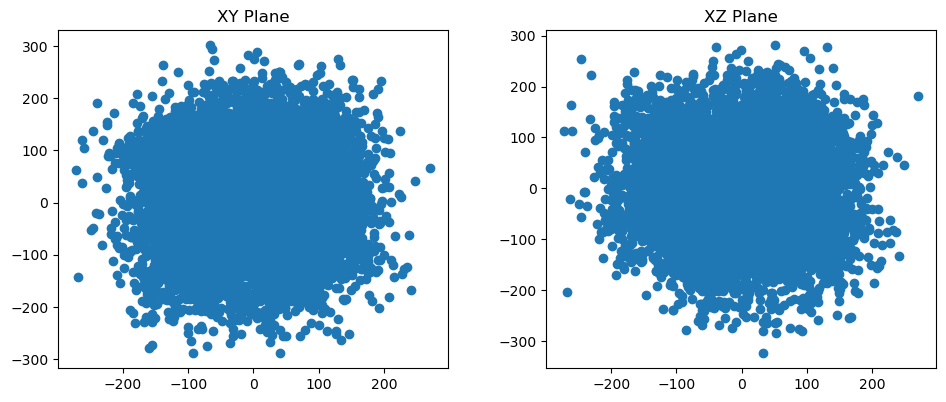

In [12]:
#2D Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].scatter(data['x'], data['y'])
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].scatter(data['x'], data['z'])
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
plt.show

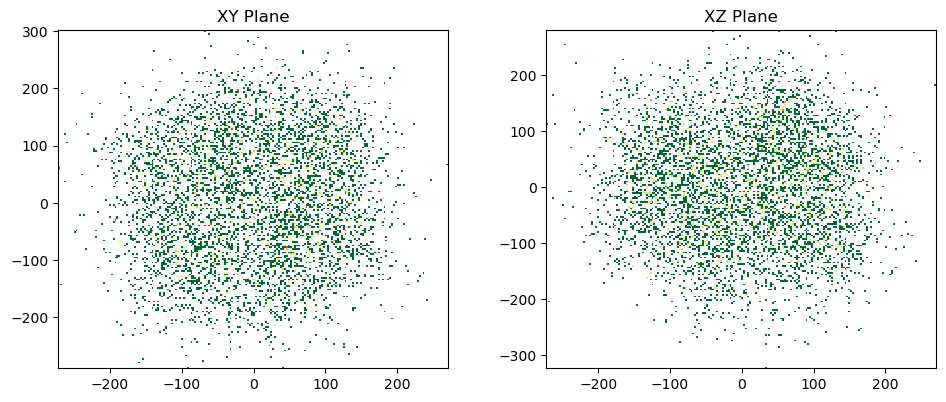

In [13]:
#2D Density Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].hist2d(data['x'], data['y'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].hist2d(data['x'], data['z'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
#plt.show

In [14]:
#construct a speck comment column
data['speck_label'] = data.Column(data=['#__'+str(name) for name in data['SOURCE_ID']], 
                                  meta=collections.OrderedDict([('ucd', 'meta.id')]),
                                  description='Gaia DR3 Source ID')

#construct a label column
data['label'] = ['GaiaDR3_'+ str(source) for source in data['SOURCE_ID']]  #leaving for now in case we want to add other labels

In [15]:
#setting texture number column
data['texnum'] = data.Column(data=[1]*len(data), 
                                  meta=collections.OrderedDict([('ucd', 'meta.texnum')]),
                                  description='Texture Number')

In [16]:
#Getting the column metadata
columns = file_functions.get_metadata(data, columns=['x', 'y', 'z', 'color', 'lum', 'absmag', 'appmag', 'texnum', 'dist_ly', 'dcalc', 'u', 'v', 'w', 'speed', 'speck_label'])
columns

,name,unit,datatype,width,precision,arraysize,ucd,description
0,x,pc,float64,,6,,pos.cartesian.x,x position (galactic cartesian coordinates) in...
1,y,pc,float64,,6,,pos.cartesian.y,Position (y coordinate) in parsecs
2,z,pc,float64,,6,,pos.cartesian.z,Position (z coordinate) in parsecs
3,color,solLum,float32,,2,,phys.color,Gaia BP-G color
4,lum,solLum,float64,,6,,phys.luminosity,Stellar Luminosity
5,absmag,mag,float64,,6,,phot.magAbs;em.opt.G,Absolute magnitude in Gaia G-band
6,appmag,mag,float32,,6,,phot.mag;em.opt.G,Apparent magnitude in Gaia G-band
7,texnum,,int32,,,,meta.texnum,Texture Number
8,dist_ly,lyr,float32,,1,,pos.distance,Distance from Sun (lyr)
9,dcalc,,int32,,,,meta.dcalc,Distance Indicator: 1 indicates a Bailer-Jones...


In [17]:
# Print the csv file using the to_csv function in file_functions
file_functions.to_csv(metadata, Table.to_pandas(data), columns)

In [18]:
# Print the speck file using the to_speck function in file_functions
file_functions.to_speck(metadata, Table.to_pandas(data), columns)

In [19]:
# Print the label file using the to_label function in file_functions
file_functions.to_label(metadata, Table.to_pandas(data))